In [1]:
bucket = 'shradhaniki'
prefix = 'sagemaker/movie'
 
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()


In [2]:
from random import shuffle

In [3]:
%cd ml-100k
!shuf ua.base -o ua.base.shuffled
!head -10 ua.base.shuffled

/home/ec2-user/SageMaker/ml-100k
621	25	4	880738699
292	169	5	881105625
297	109	4	874954814
621	386	3	874963126
85	984	2	884906441
916	475	4	880843334
373	739	3	877111819
452	171	4	875277472
334	529	5	891547445
3	354	3	889237004


In [5]:
!head -10 ua.test

1	20	4	887431883
1	33	4	878542699
1	61	4	878542420
1	117	3	874965739
1	155	2	878542201
1	160	4	875072547
1	171	5	889751711
1	189	3	888732928
1	202	5	875072442
1	265	4	878542441


In [7]:
import pandas as pd
data = pd.read_csv("ua.base.shuffled", sep='\t', header=None, names=['userid', 'movieid', 'rating', 'timestamp'])

nbUsers = data['userid'].max()
nbMovies = data['movieid'].max()
nbFeatures = nbUsers + nbMovies
print("Number of Users: %d" % nbUsers)
print("Number of Movies: %d" % nbMovies)
print("Number of Features: %d" % nbFeatures)

Number of Users: 943
Number of Movies: 1682
Number of Features: 2625


In [8]:
movies_by_user = data.groupby('userid')
res = movies_by_user['movieid'].count().hist(bins=100)
res.set_title('Rating count distribution')
res

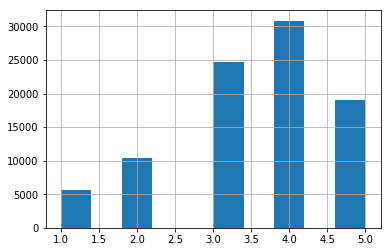

In [9]:
data['rating'].hist()

In [10]:
nbRatingsTrain = 90570
nbRatingsTest = 9430

In [12]:
import csv
import numpy as np
from scipy.sparse import lil_matrix

# For each user, build a list of rated movies.
# We'd need this to add random negative samples.
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)] = []
 
with open('ua.base.shuffled', 'r') as f:
    samples = csv.reader(f, delimiter = '\t')
    for userId, movieId, rating, timestamp in samples:
        moviesByUser[str(int(userId) - 1)].append(int(movieId) - 1)

In [13]:
def loadDataset(filename, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line = 0
    with open(filename, 'r') as f:
        samples = csv.reader(f, delimiter = '\t')
        for userId, movieId, rating, timestamp in samples:
            X[line, int(userId) - 1] = 1
            X[line, int(nbUsers) + int(movieId)-1] = 1
            if int(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line = line + 1
            
    Y = np.array(Y).astype('float32')
    return X, Y

In [14]:
X_train, Y_train = loadDataset('ua.base.shuffled', nbRatingsTrain, nbFeatures)
X_test, Y_test = loadDataset('ua.test', nbRatingsTest, nbFeatures)

In [15]:
print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (nbRatingsTrain, nbFeatures)
assert Y_train.shape == (nbRatingsTrain, )
zero_labels = np.count_nonzero(Y_train)
print("Training labels: %d zeros, %d ones" % (zero_labels, nbRatingsTrain-zero_labels))

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (nbRatingsTest, nbFeatures)
assert Y_test.shape  == (nbRatingsTest, )
zero_labels = np.count_nonzero(Y_test)
print("Test labels: %d zeros, %d ones" % (zero_labels, nbRatingsTest-zero_labels))

(90570, 2625)
(90570,)
Training labels: 49906 zeros, 40664 ones
(9430, 2625)
(9430,)
Test labels: 5469 zeros, 3961 ones


In [16]:
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test')

output_location  = 's3://{}/{}/output'.format(bucket, prefix)


In [17]:
import sagemaker.amazon.common as smac
import io

def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    

print('uploaded training data location: {}'.format(train_data))
print('uploaded test data location: {}'.format(test_data))
print('training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://shradhaniki/sagemaker/movie/train/train.protobuf
uploaded test data location: s3://shradhaniki/sagemaker/movie/test/test.protobuf
training artifacts will be uploaded to: s3://shradhaniki/sagemaker/movie/output


In [18]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

In [19]:
import sagemaker

sess = sagemaker.Session()

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=100)

fm.fit({'train': train_data, 'test': test_data})

2019-10-25 23:22:18 Starting - Starting the training job...
2019-10-25 23:22:25 Starting - Launching requested ML instances.........
2019-10-25 23:23:54 Starting - Preparing the instances for training...
2019-10-25 23:24:47 Downloading - Downloading input data...
2019-10-25 23:25:14 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/pandas/util/nosetester.py:13: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing import nosetester
[10/25/2019 23:25:31 INFO 140236324661056] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'factors_lr': u'0.0001', u'linear_init_sigma': u'0.01', u'epochs': 1, u'_wd': u'1.0', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'factors_init_sigma': u'0.001', u'_log_level': u'info', u'bias_init_method': u'normal', u'linear_init_method


2019-10-25 23:25:27 Training - Training image download completed. Training in progress.[2019-10-25 23:25:36.287] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 18, "duration": 526, "num_examples": 91, "num_bytes": 5796480}
[10/25/2019 23:25:36 INFO 140236324661056] #quality_metric: host=algo-1, epoch=8, train binary_classification_accuracy <score>=0.705021978022
[10/25/2019 23:25:36 INFO 140236324661056] #quality_metric: host=algo-1, epoch=8, train binary_classification_cross_entropy <loss>=0.619986362332
[10/25/2019 23:25:36 INFO 140236324661056] #quality_metric: host=algo-1, epoch=8, train binary_f_1.000 <score>=0.764710522856
#metrics {"Metrics": {"update.time": {"count": 1, "max": 528.311014175415, "sum": 528.311014175415, "min": 528.311014175415}}, "EndTime": 1572045936.288117, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1572045935.75923}

[10/25/2019 23:25:36 INFO 14023632466

[2019-10-25 23:25:46.414] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 56, "duration": 522, "num_examples": 91, "num_bytes": 5796480}
[10/25/2019 23:25:46 INFO 140236324661056] #quality_metric: host=algo-1, epoch=27, train binary_classification_accuracy <score>=0.732263736264
[10/25/2019 23:25:46 INFO 140236324661056] #quality_metric: host=algo-1, epoch=27, train binary_classification_cross_entropy <loss>=0.561597676371
[10/25/2019 23:25:46 INFO 140236324661056] #quality_metric: host=algo-1, epoch=27, train binary_f_1.000 <score>=0.768491068035
#metrics {"Metrics": {"update.time": {"count": 1, "max": 523.7479209899902, "sum": 523.7479209899902, "min": 523.7479209899902}}, "EndTime": 1572045946.415217, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1572045945.89077}

[10/25/2019 23:25:46 INFO 140236324661056] #progress_metric: host=algo-1, completed 28 % of epochs
#metrics {"Metrics":

[2019-10-25 23:25:56.163] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 92, "duration": 523, "num_examples": 91, "num_bytes": 5796480}
[10/25/2019 23:25:56 INFO 140236324661056] #quality_metric: host=algo-1, epoch=45, train binary_classification_accuracy <score>=0.742736263736
[10/25/2019 23:25:56 INFO 140236324661056] #quality_metric: host=algo-1, epoch=45, train binary_classification_cross_entropy <loss>=0.540574135581
[10/25/2019 23:25:56 INFO 140236324661056] #quality_metric: host=algo-1, epoch=45, train binary_f_1.000 <score>=0.774149357979
#metrics {"Metrics": {"update.time": {"count": 1, "max": 525.4919528961182, "sum": 525.4919528961182, "min": 525.4919528961182}}, "EndTime": 1572045956.164057, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1572045955.637963}

[10/25/2019 23:25:56 INFO 140236324661056] #progress_metric: host=algo-1, completed 46 % of epochs
#metrics {"Metrics"

[2019-10-25 23:26:06.362] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 130, "duration": 525, "num_examples": 91, "num_bytes": 5796480}
[10/25/2019 23:26:06 INFO 140236324661056] #quality_metric: host=algo-1, epoch=64, train binary_classification_accuracy <score>=0.745648351648
[10/25/2019 23:26:06 INFO 140236324661056] #quality_metric: host=algo-1, epoch=64, train binary_classification_cross_entropy <loss>=0.528072608361
[10/25/2019 23:26:06 INFO 140236324661056] #quality_metric: host=algo-1, epoch=64, train binary_f_1.000 <score>=0.775860399357
#metrics {"Metrics": {"update.time": {"count": 1, "max": 527.1379947662354, "sum": 527.1379947662354, "min": 527.1379947662354}}, "EndTime": 1572045966.362738, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1572045965.834978}

[10/25/2019 23:26:06 INFO 140236324661056] #progress_metric: host=algo-1, completed 65 % of epochs
#metrics {"Metrics

[2019-10-25 23:26:16.037] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 166, "duration": 524, "num_examples": 91, "num_bytes": 5796480}
[10/25/2019 23:26:16 INFO 140236324661056] #quality_metric: host=algo-1, epoch=82, train binary_classification_accuracy <score>=0.747725274725
[10/25/2019 23:26:16 INFO 140236324661056] #quality_metric: host=algo-1, epoch=82, train binary_classification_cross_entropy <loss>=0.520334832831
[10/25/2019 23:26:16 INFO 140236324661056] #quality_metric: host=algo-1, epoch=82, train binary_f_1.000 <score>=0.777615251233
#metrics {"Metrics": {"update.time": {"count": 1, "max": 525.7630348205566, "sum": 525.7630348205566, "min": 525.7630348205566}}, "EndTime": 1572045976.038396, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "factorization-machines"}, "StartTime": 1572045975.512038}

[10/25/2019 23:26:16 INFO 140236324661056] #progress_metric: host=algo-1, completed 83 % of epochs
#metrics {"Metrics


2019-10-25 23:26:35 Uploading - Uploading generated training model
2019-10-25 23:26:35 Completed - Training job completed
Training seconds: 108
Billable seconds: 108


In [20]:
fm_predictor = fm.deploy(initial_instance_count=1,
                         instance_type='ml.c5.xlarge')

---------------------------------------------------------------------------------------!

In [21]:
import json
from sagemaker.predictor import json_deserializer

def fm_serializer(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)

fm_predictor.content_type = 'application/json'
fm_predictor.serializer = fm_serializer
fm_predictor.deserializer = json_deserializer

In [22]:
prediction = X_test[1000].toarray()
result = fm_predictor.predict(prediction)

print(Y_test[1000])
print(result)

0.0
{'predictions': [{'score': 0.6729488968849182, 'predicted_label': 1.0}]}


In [23]:
import numpy as np

predictions = []
for array in np.array_split(X_test[1000:1100].toarray(), 1):
    result = fm_predictor.predict(array)
    predictions += [r['predicted_label'] for r in result['predictions']]

predictions = np.array(predictions)

In [24]:
import pandas as pd

pd.crosstab(Y_test[1000:1100], predictions, rownames=['actuals'], colnames=['predictions'])


predictions,0.0,1.0
actuals,,
0.0,45,16
1.0,21,18
